In [2]:
print("Hello world")

Hello world


# Semi Empirical Mass Formula
B.E. = $a_vA +$

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import emcee
# data= pd.read_csv("semf.csv", header=0, names=['A', 'Z', 'm_atom', 'error'])
# A = data['A']
# Z = data['Z']
# m_atom = data['m_atom']
# el = data['error']
# A = np.array(A)
# Z = np.array(Z)
# m_atom = np.array(m_atom)
# el = np.array(el)

In [4]:
df = pd.read_csv(
    "ame2020.tsv",
    sep="\t",
    header=None,
    names=["nuclide","mass","uncertainty","ref"]
)

df["mass"] = pd.to_numeric(df["mass"])
df["uncertainty"] = pd.to_numeric(df["uncertainty"])

df.head()

,nuclide,mass,uncertainty,ref
0,1H,1.007825,1.400000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...
1,2H,2.014102,1.500000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...
2,3H,3.016049,8.000000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...
3,3He,3.016029,6.000000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...
4,3Li,3.030775,2.147000e-03,<a href='https://doi.org/10.1088/1674-1137/abd...


In [5]:
def split_nuclide(n):
    m = re.match(r"(\d+)([A-Za-z]+)", n)
    return int(m.group(1)), m.group(2)

df[["A","symbol"]] = df["nuclide"].apply(
    lambda x: pd.Series(split_nuclide(x))
)

df.head()

,nuclide,mass,uncertainty,ref,A,symbol
0,1H,1.007825,1.400000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,1,H
1,2H,2.014102,1.500000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,2,H
2,3H,3.016049,8.000000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,3,H
3,3He,3.016029,6.000000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,3,He
4,3Li,3.030775,2.147000e-03,<a href='https://doi.org/10.1088/1674-1137/abd...,3,Li


In [6]:
elements = [
"H","He","Li","Be","B","C","N","O","F","Ne",
"Na","Mg","Al","Si","P","S","Cl","Ar",
"K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co","Ni","Cu","Zn",
"Ga","Ge","As","Se","Br","Kr",
"Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd",
"In","Sn","Sb","Te","I","Xe",
"Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy",
"Ho","Er","Tm","Yb","Lu",
"Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg",
"Tl","Pb","Bi","Po","At","Rn",
"Fr","Ra","Ac","Th","Pa","U","Np","Pu","Am","Cm","Bk","Cf",
"Es","Fm","Md","No","Lr",
"Rf","Db","Sg","Bh","Hs","Mt","Ds","Rg","Cn",
"Nh","Fl","Mc","Lv","Ts","Og"
]

periodic_table = {symbol: i+1 for i, symbol in enumerate(elements)}

df["Z"] = df["symbol"].map(periodic_table)

df.head()

,nuclide,mass,uncertainty,ref,A,symbol,Z
0,1H,1.007825,1.400000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,1,H,1
1,2H,2.014102,1.500000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,2,H,1
2,3H,3.016049,8.000000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,3,H,1
3,3He,3.016029,6.000000e-11,<a href='https://doi.org/10.1088/1674-1137/abd...,3,He,2
4,3Li,3.030775,2.147000e-03,<a href='https://doi.org/10.1088/1674-1137/abd...,3,Li,3


In [7]:
m_H = 1.007825032
m_n = 1.008664916
m_e = 0.000548579909
u_to_MeV = 931.49410242

m_nucleus = df["mass"] - df["Z"]*m_e
m_nucleons = df["Z"]*m_H + (df["A"]-df["Z"])*m_n

mass_defect = m_nucleons - m_nucleus

df["BE"] = mass_defect * u_to_MeV
df["BE_per_A"] = df["BE"] / df["A"]
df["sigma_BE"] = df["uncertainty"] * u_to_MeV

#### Converting to numpy arrays

In [8]:
A = df["A"].values
Z = df["Z"].values
BE = df["BE"].values
sigma = df["sigma_BE"].values

#### Begin here

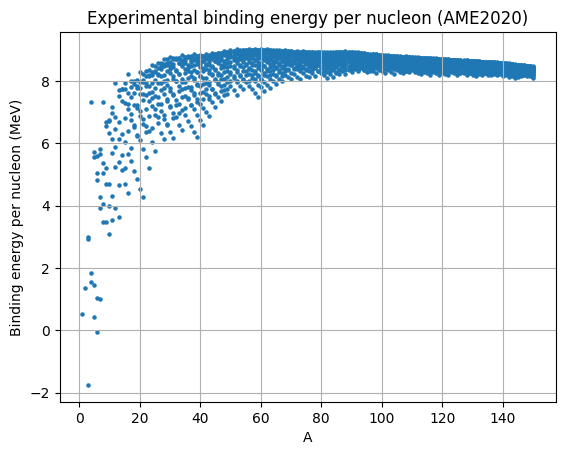

In [ ]:
plt.scatter(df['A'], df['BE_per_A'], s=5)
plt.xlabel("A")
plt.ylabel("Binding energy per nucleon (MeV)")
plt.title("Experimental binding energy per nucleon (AME2020)")
plt.grid()
plt.show()

In [ ]:
def E_B_theory(a_v, a_s, a_c, a_asy, a_p, A, Z):
    A = np.asarray(A, dtype=float)
    Z = np.asarray(Z, dtype=float)
    N = A - Z
    # Precompute powers (faster + cleaner)
    A_third = A**(1/3)
    A_two_third = A_third**2
    A_half = np.sqrt(A)
    # Pairing term (vectorized and clearer)
    even_Z = (Z % 2 == 0)
    even_N = (N % 2 == 0)
    pairing = np.zeros_like(A)
    pairing[ even_Z &  even_N] =  a_p      # even-even
    pairing[~even_Z & ~even_N] = -a_p      # odd-odd
    # odd-even already zero
    volume = a_v * A
    surface = a_s * A_two_third
    coulomb = a_c * Z*(Z-1) / A_third
    asymmetry = a_asy * (A - 2*Z)**2 / A
 
    B = ( volume - surface - coulomb - asymmetry + pairing / A_half )
    return B

In [ ]:
# ---- Parameter scaling (brings parameters ~O(1)) ----
scales = np.array([15.0, 17.0, 0.7, 23.0, 12.0, 1.0])
# [a_v, a_s, a_c, a_asy, a_p, sigma]
def ln_prior(theta_scaled):
    theta = theta_scaled * scales
    a_v, a_s, a_c, a_asy, a_p, sigma = theta
    # Physical constraint
    if sigma <= 0:
        return -np.inf
    lp = 0.0
    # Weak Gaussian priors (wide)
    lp += -0.5 * ((a_v - 15)/5)**2
    lp += -0.5 * ((a_s - 17)/5)**2
    lp += -0.5 * ((a_c - 0.7)/0.3)**2
    lp += -0.5 * ((a_asy - 23)/5)**2
    lp += -0.5 * ((a_p - 12)/8)**2
    # Half-normal prior on sigma
    lp += -0.5 * (sigma/2)**2
    return lp

def ln_likelihood(theta_scaled, A, Z, BE):
    theta = theta_scaled * scales
    a_v, a_s, a_c, a_asy, a_p, sigma = theta
    model = E_B_theory(a_v, a_s, a_c, a_asy, a_p, A, Z)
    residuals = BE - model
    return -0.5 * np.sum(
        (residuals / sigma)**2 + np.log(2*np.pi*sigma**2)
    )
    
def ln_post(theta_scaled, A, Z, BE):
    lp = ln_prior(theta_scaled)
    if not np.isfinite(lp):
        return -np.inf
    ll = ln_likelihood(theta_scaled, A, Z, BE)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [12]:
ndim = 6                 # 5 SEMF parameters + sigma
nwalkers = 32            # >= 4 * ndim (good practice)
nsteps = 8000
burnin = 1500
np.random.seed(42)
init_physical = np.array([15.0, 17.0, 0.7, 23.0, 12.0, 1.0])
init_scaled = init_physical / scales
pos = init_scaled + 0.05 * np.random.randn(nwalkers, ndim)

### burnin
=  2 × max(tau)

In [13]:
import multiprocessing

if __name__ == "__main__":

    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            ln_post,
            args=(A, Z, BE),
            pool=pool
        )

        sampler.run_mcmc(pos, nsteps, progress=True)

    # ---- Remove burn-in properly ----
    chain = sampler.get_chain(discard=burnin, flat=False)
    flat_samples = sampler.get_chain(discard=burnin, flat=True)

    print("Flat sample shape:", flat_samples.shape)

    # ---- Diagnostics ----
    print("Mean acceptance fraction:",
          np.mean(sampler.acceptance_fraction))

    try:
        tau = sampler.get_autocorr_time()
        print("Autocorrelation time:", tau)
    except:
        print("Autocorrelation time could not be estimated reliably.")

100%|██████████| 8000/8000 [03:11<00:00, 41.86it/s]


Flat sample shape: (208000, 6)
Mean acceptance fraction: 0.51415625
Autocorrelation time could not be estimated reliably.


In [17]:
# Unscale samples back to physical units
samples_physical = flat_samples * scales

a_v   = samples_physical[:, 0]
a_s   = samples_physical[:, 1]
a_c   = samples_physical[:, 2]
a_asy = samples_physical[:, 3]
a_p   = samples_physical[:, 4]
sigma = samples_physical[:, 5]
def summarize(param, name):
    median = np.percentile(param, 50)
    low = np.percentile(param, 16)
    high = np.percentile(param, 84)

    print(f"{name} = {median:.3f} (+{high-median:.3f}, -{median-low:.3f})")
print("\n---- Posterior Estimates ----")

summarize(a_v,   "a_v")
summarize(a_s,   "a_s")
summarize(a_c,   "a_c")
summarize(a_asy, "a_asy")
summarize(a_p,   "a_p")
summarize(sigma, "sigma")


---- Posterior Estimates ----
a_v = 14.690 (+0.022, -0.023)
a_s = 14.488 (+0.062, -0.062)
a_c = 0.604 (+0.002, -0.002)
a_asy = 20.058 (+0.065, -0.066)
a_p = 9.627 (+0.797, -0.811)
sigma = 3.458 (+0.056, -0.054)


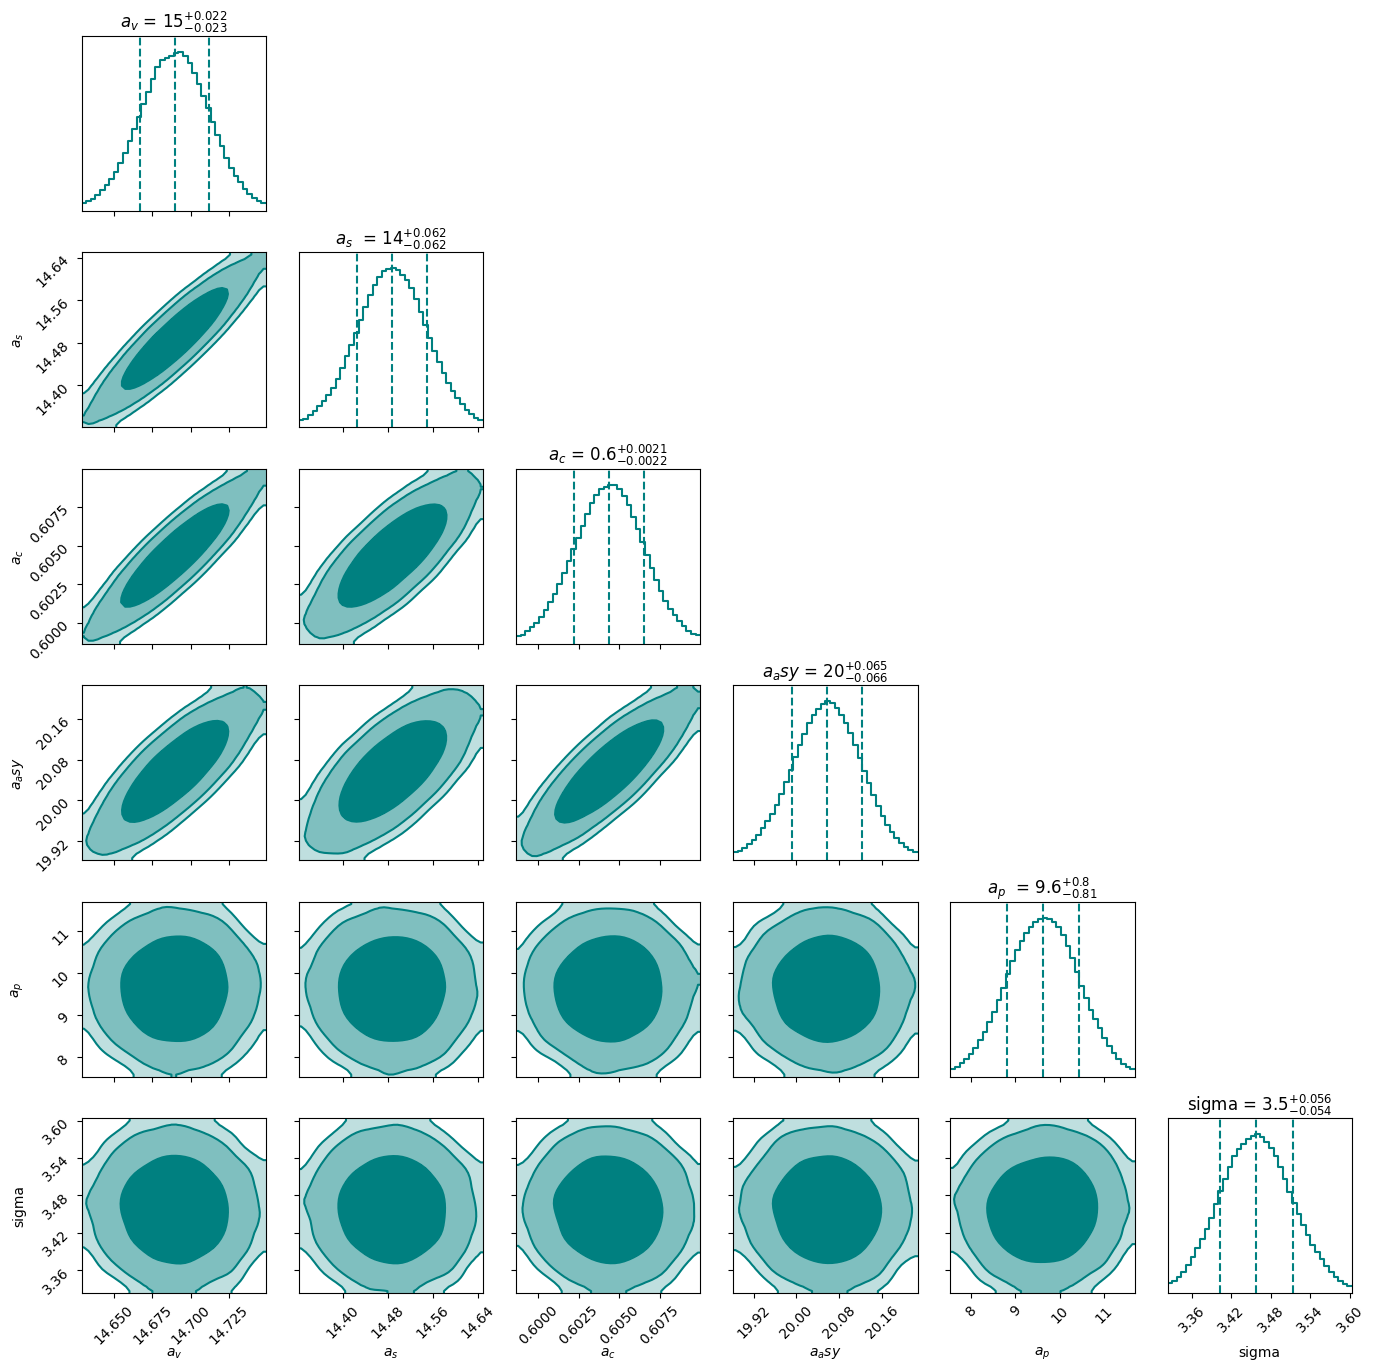

In [19]:
import corner

ranges = []
for i in range(samples_physical.shape[1]):
    lo, hi = np.percentile(samples_physical[:, i], [0.5, 99.5])
    ranges.append((lo, hi))

corner.corner(samples_physical,                                                                            
    labels=["$a_v$", "$a_s$ ", "$a_c$", "$a_asy$", "$a_p$ ", "sigma"],
    bins=40,
    color="teal",
    quantiles=[0.16, 0.5, 0.84],
    plot_contours=True,
    fill_contours=True,
    levels=(0.68, 0.95, 0.99),
    plot_datapoints=False,         # cleaner plots
    smooth=2.0, smooth1d=1.0,
    title_fmt=".2g",
    show_titles=True,
    range=ranges
)
plt.tight_layout()
plt.show()

#### Median posterior values

In [20]:
a_v_med   = np.percentile(a_v, 50)
a_s_med   = np.percentile(a_s, 50)
a_c_med   = np.percentile(a_c, 50)
a_asy_med = np.percentile(a_asy, 50)
a_p_med   = np.percentile(a_p, 50)
B_model = E_B_theory(a_v_med, a_s_med, a_c_med, a_asy_med, a_p_med, A, Z)

B_exp = df['BE'].values   

## Plots

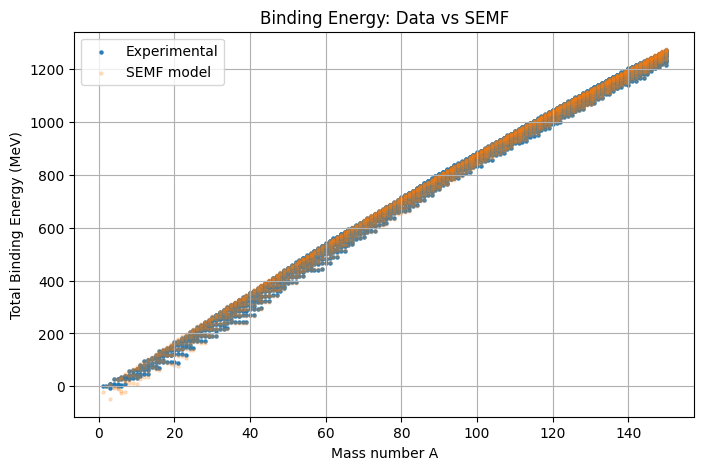

In [23]:
plt.figure(figsize=(8,5))

plt.scatter(A, B_exp, s=5, label="Experimental", alpha=0.9)
plt.scatter(A, B_model, s=5, label="SEMF model", alpha=0.2)
plt.xlabel("Mass number A")
plt.ylabel("Total Binding Energy (MeV)")
plt.title("Binding Energy: Data vs SEMF")
plt.legend()
plt.grid()
plt.show()

### Residual plot

/tmp/ipykernel_1389/1837087673.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


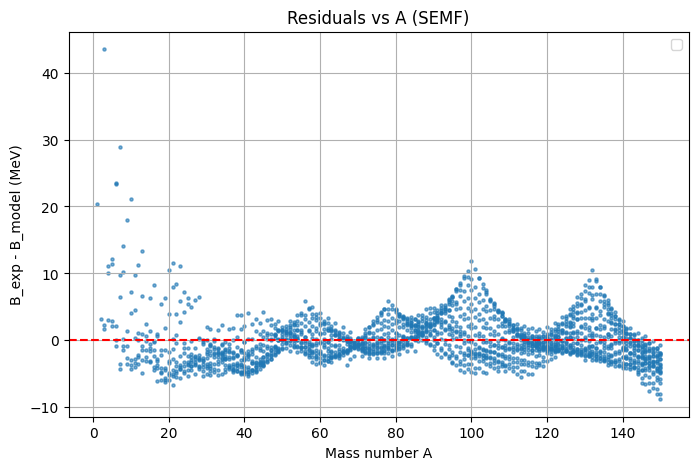

In [ ]:
residuals = B_exp - B_model
plt.figure(figsize=(8,5))
plt.scatter(A, residuals, s=5, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Mass number A")
plt.ylabel("B_exp - B_model (MeV)")
plt.title("Residuals vs A (SEMF)")
plt.legend()
plt.grid()
plt.show()

In [26]:
np.std(residuals)

np.float64(3.454249040972637)

### emcee chains shape: 
(nsteps, nwalkers, ndim)
when flattened: (nsteps × nwalkers, ndim)

N $\ge 50 \times \tau$ 
Repeat until
N > 50 × max(tau)


### All sampled values of the 5 parameters

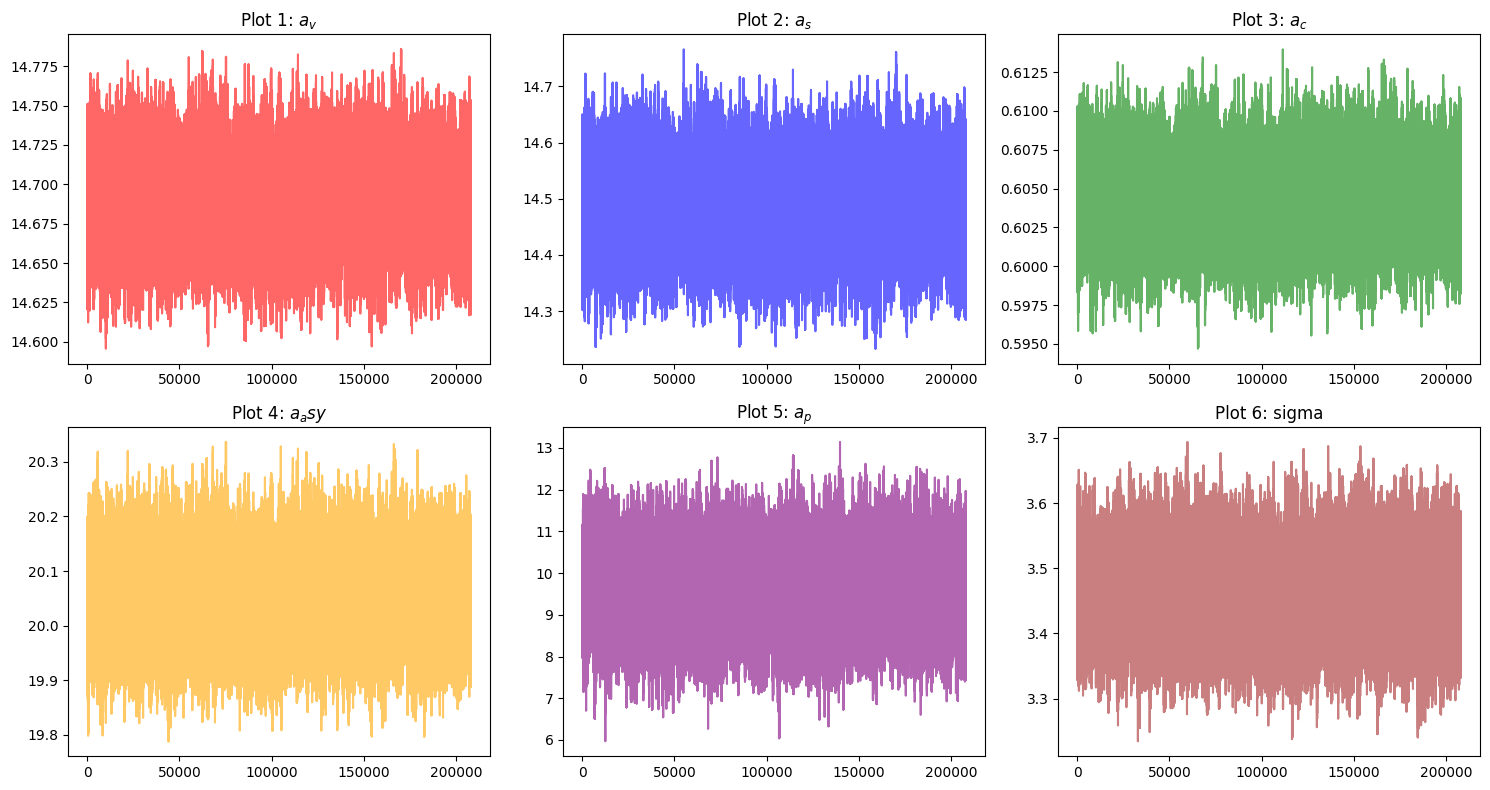

In [28]:
# Setup: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Flatten for easier indexing
axes = axes.flatten()

# Plot 1
axes[0].plot(a_v, alpha=0.6, color='red')
axes[0].set_title("Plot 1: $a_v$")

# Plot 2
axes[1].plot(a_s, alpha=0.6, color='blue')
axes[1].set_title("Plot 2: $a_s$")

# Plot 3
axes[2].plot(a_c, alpha=0.6, color='green')
axes[2].set_title("Plot 3: $a_c$")

# Plot 4
axes[3].plot(a_asy, alpha=0.6, color='orange')
axes[3].set_title("Plot 4: $a_asy$")

# Plot 5
axes[4].plot(a_p, alpha=0.6, color='purple')
axes[4].set_title("Plot 5: $a_p$")

# Plot 6 (sigma)
axes[5].plot(sigma, alpha=0.6, color='brown')
axes[5].set_title("Plot 6: sigma")

plt.tight_layout()
plt.show()